# SBERT and Semantic Search

## Task Description
Create something innovative using SBERT and semantic search, or even more! The guidelines are intentionally broad to encourage creativity. Here are some ideas to get you started:
- Implement a semantic search engine (Text, Image or YouTube search function using CLIP).
- Use the Hugging Face pipeline to summarize or classify the query research results.
- (Optional) Use SetFit for supervised tasks with SBERT models.
- Consider building a search engine using a Gradio or Streamlit app.

## Data
- You may utilize datasets from 🤗 Hugging Face, Kaggle, or create your own.
- For inspiration, refer to the GIF search engine and YouTube search projects.

## Delivery
- Create a dedicated GitHub repository for this assignment.
- Store all relevant materials, including the Colab notebook, in the repository.
- Provide a README.md file with a concise description of the assignment and its components.
- You may work individually or in groups of up to three members.
- Submit your work by emailing a link to the repository to Hamid (hamidb@business.aau.dk).



## We start by importing the necessary packages

In [ ]:
!pip install transformers --q

In [ ]:
!pip install -U sentence-transformers --q

In [ ]:
!pip install nlp datasets --q

In [ ]:
!pip install gradio -q

In [ ]:
!pip install setfit -q

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import torch.nn as nn
import json
import os
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
from sklearn.cluster import KMeans
from PIL import Image
import glob
import pickle
from datasets import Dataset
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
from tqdm.autonotebook import tqdm
from transformers import pipeline
from transformers import set_seed
import random
import itertools
from tokenizers import Tokenizer
from datetime import datetime
import re
import scipy.spatial
import gradio as gr
from setfit import SetFitModel, SetFitTrainer
from sklearn.metrics import accuracy_score
import evaluate
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from setfit import SetFitModel, Trainer, TrainingArguments, sample_dataset

## Dataset
We import the imdb dataset, and extract the reviews and sentiment.

In [ ]:
imdb = load_dataset("imdb")
reviews = imdb["train"]["text"]  # Extract reviews
sentiments = imdb["train"]["label"]  # Extract sentiments

print(f"Loaded {len(reviews)} reviews.")
print(f"First review: {reviews[0]}")

Loaded 25000 reviews.
First review: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity

## Implementing search engine
Here we start the modeling by preparing the SBERT and corpus that we will apply the model upon. Lastly we use a search query to find the reviews that match the sentence "A thrilling and suspenseful movie" the most.

In [ ]:
# Load the SBERT model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode IMDb reviews into embeddings
corpus_embeddings = model.encode(reviews, convert_to_tensor=True, show_progress_bar=True)

# Search Function for IMDb Reviews
def search_reviews(query):
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Perform semantic search
    search_hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=5)[0]

    print("\n\nQuery:", query)
    print("Most similar reviews:")
    for hit in search_hits:
        review = reviews[hit["corpus_id"]]
        sentiment = "positive" if sentiments[hit["corpus_id"]] == 1 else "negative"
        print(f"Score: {hit['score']:.2f} | Sentiment: {sentiment} | Review: {review[:200]}...")

# Example usage
search_reviews("A thrilling and suspenseful movie")

Batches:   0%|          | 0/782 [00:00<?, ?it/s]



Query: A thrilling and suspenseful movie
Most similar reviews:
Score: 0.71 | Sentiment: positive | Review: A suspenseful thriller that bears some resemblance to Deliverance as for scenery and setting. There are also some very innovatively shot scenes and good music, although the daftness and sometimes seem...
Score: 0.67 | Sentiment: negative | Review: The genre of suspense films really takes a dive in this one. The big problem is IMPLAUSABILITY. I realize that you need to create difficult situations which would cause suspense and the tense feeling ...
Score: 0.66 | Sentiment: positive | Review: This is how movies are supposed to be made: a fascinating setting; characters about whom you come to care deeply; writing and editing that move the plot efficiently and build suspense. This is a wonde...
Score: 0.66 | Sentiment: positive | Review: An inventive, suspenseful exercise in claustrophobia. A Japanese thriller that sets itself a tough challenge by being entirely set in two rooms. No

Here we get a basic score for the similarity to the chosen review, what sentiment the review en general is and the review.


## Hugging Face pipelines for summarization and classification

Here we utilize hugging face to get classification on the reviews for further anaysis. Here we replicate the previous search engine but with hugging face.

In [ ]:
# Load Hugging Face pipelines for summarization and classification
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define the search function with summarization and classification
def search_and_summarize_reviews(query, classification_labels=None):
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Perform semantic search
    search_hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=5)[0]

    print("\n\nQuery:", query)
    print("Most similar reviews:")
    for hit in search_hits:
        related_review = reviews[hit["corpus_id"]]
        sentiment = "positive" if sentiments[hit["corpus_id"]] == 1 else "negative"

        # Summarize the review
        summarized_text = summarizer(related_review, max_length=50, min_length=10, do_sample=False)[0]["summary_text"]

        # Optionally classify the review
        if classification_labels:
            classification = classifier(related_review, candidate_labels=classification_labels)
            top_label = classification["labels"][0]
            confidence = classification["scores"][0]
        else:
            top_label, confidence = None, None

        # Print results
        print(f"\nScore: {hit['score']:.2f}")
        print(f"Sentiment: {sentiment}")
        print(f"Summary: {summarized_text}")
        if classification_labels:
            print(f"Classification: {top_label} (Confidence: {confidence:.2f})")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
search_and_summarize_reviews(
    query="A thrilling and suspenseful movie",
    classification_labels=["Drama", "Action", "Comedy", "Thriller"]
)



Query: A thrilling and suspenseful movie
Most similar reviews:

Score: 0.71
Sentiment: positive
Summary: A suspenseful thriller that bears some resemblance to Deliverance as for scenery and setting. There are also some very innovatively shot scenes and good music.
Classification: Thriller (Confidence: 0.90)

Score: 0.67
Sentiment: negative
Summary: The genre of suspense films really takes a dive in this one. The big problem is IMPLAUSABILITY. If they took the time to make it more realistic, I might have enjoyed it a little.
Classification: Action (Confidence: 0.41)

Score: 0.66
Sentiment: positive
Summary: This is how movies are supposed to be made: a fascinating setting and characters about whom you come to care deeply. The film is deeply moving without being sentimental.
Classification: Drama (Confidence: 0.36)

Score: 0.66
Sentiment: positive
Summary: An inventive, suspenseful exercise in claustrophobia. A Japanese thriller that sets itself a tough challenge by being entirely set 

The Hugging face model has given the same results and here we have expanded the use of the model to give summary, classification confidence and classification type for each of the recommended reviews that is alike.

## SetFit for supervised tasks with SBERT models (Predicting the length of the review)



By using SetFit we can do supervised tasks with SBERT, her we will setup the model and evaluate on the results. We try to predict the length of the review, since this was something we could think of that didnt give a binary outcome such as when trying to predict the bad guy or sentiment, which is way to easy for the model to find in the reviews.

In [ ]:
# Load IMDb dataset
dataset = load_dataset("imdb")
reviews = dataset["train"]["text"][:1000]
# Create a dataset with review text and its length (number of characters)
data = [
    {
        "text": review,
        "text_length": len(review),  # Length of the review (target)
    }
    for review in reviews
]

# Convert to DataFrame
df = pd.DataFrame(data)

#Split into Train/Test sets
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["text_length"], test_size=0.2, random_state=42
)

# Load and Encode Text with SetFitModel
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-MiniLM-L6-v2")

# Generate embeddings for train and test sets
X_train_embeddings = model.encode(X_train.tolist(), show_progress_bar=True)
X_test_embeddings = model.encode(X_test.tolist(), show_progress_bar=True)

# Train a Regression Model on the Embeddings
regressor = RandomForestRegressor(random_state=42, n_estimators=100)
regressor.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test_embeddings)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.2f}")


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Mean Squared Error: 817206.63
Mean Absolute Error: 653.84
R-squared: 0.04


We prepare the data for training with the review length parameters, from there we split the data for training and testing at 80/20 split. Then the data is used with SetFit and randomForest to create embeddings of the text to evaluate. From the MSE we see that the average squared difference between predicted and actual, where its very high suggesting its hard to predict the length of the reviews. MAE is the mean absolute error which shows that on average the error of the prediction is 653,84 characters. The R^2 shows that the model only explains 0.04% of the length of the review.


# Semantic Search Heatmap

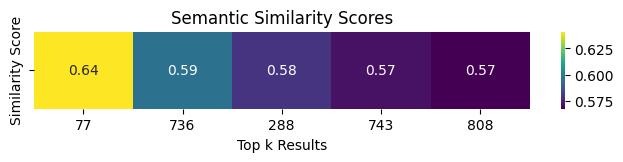

In [ ]:
#Load SBERT Model
model = SentenceTransformer("all-MiniLM-L6-v2")

#Encode Reviews
corpus_embeddings = model.encode(reviews, convert_to_tensor=True)

#Define a Query
query = "A thrilling and suspenseful movie"
query_embedding = model.encode(query, convert_to_tensor=True)

# Perform Semantic Search
search_hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=5)[0]

# Create Heatmap Function
def create_heatmap(search_hits):
    scores = [hit["score"] for hit in search_hits]  # Extract similarity scores
    indices = [hit["corpus_id"] for hit in search_hits]  # Get review indices

    plt.figure(figsize=(8, 1))
    sns.heatmap(
        [scores], annot=True, cmap="viridis", fmt=".2f", cbar=True,
        xticklabels=indices, yticklabels=["Similarity Score"]
    )
    plt.title("Semantic Similarity Scores")
    plt.xlabel("Top k Results")
    plt.show()

# Plot the Heatmap
create_heatmap(search_hits)


Here we see the heatmap of the clusters in the similarity to the query. It shows the 5 most similar reviews, ranging from a similarity of 64% to 57%. It also shows which review number that is most similar to it.

# Clustering Results Visualization


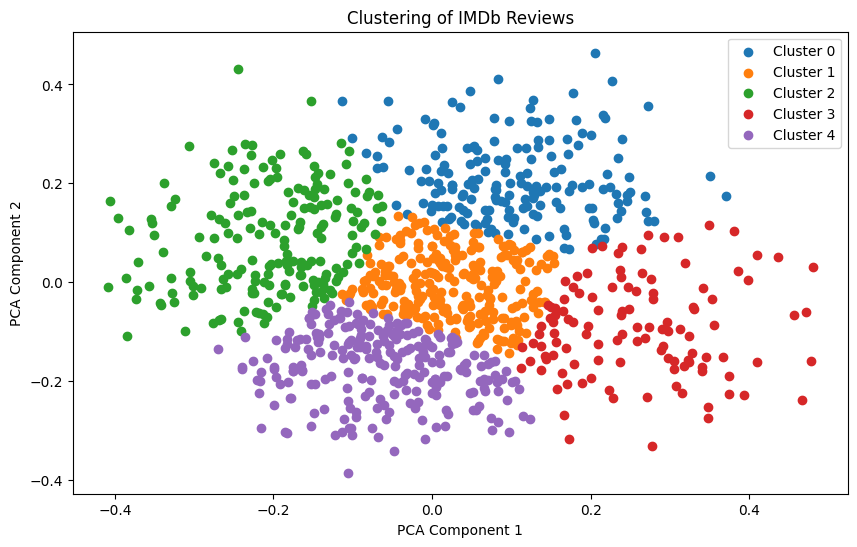

In [ ]:
corpus_embeddings = model.encode(reviews, convert_to_tensor=False)
def plot_clusters(n_clusters=5):
    # Apply PCA to reduce dimensions for visualization
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(corpus_embeddings)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(reduced_embeddings)

    # Plot clusters
    plt.figure(figsize=(10, 6))
    for cluster in np.unique(clusters):
        cluster_points = reduced_embeddings[clusters == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

    plt.title("Clustering of IMDb Reviews")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()

# Plot Clusters
plot_clusters()

We can see that there is 5 strong and well defined clusters, showing that up to 4 PCA components counting from 0, could be used.

# Network Graph of the reviews

In [ ]:
import plotly.graph_objects as go
def plotly_network_graph(cluster_labels, reduced_embeddings, threshold=0.6):
    """
    Create an interactive network graph using Plotly in Google Colab.
    """
    G = nx.Graph()

    # Add nodes with cluster-based coloring
    for idx, cluster in enumerate(cluster_labels):
        G.add_node(idx, cluster=cluster)

    # Add edges based on similarity
    for i in range(len(cluster_labels)):
        for j in range(i + 1, len(cluster_labels)):
            similarity = util.pytorch_cos_sim(corpus_embeddings[i], corpus_embeddings[j]).item()
            if similarity >= threshold:
                G.add_edge(i, j, weight=similarity)

    # Extract node positions for visualization
    pos = nx.spring_layout(G, seed=42)

    # Create edge traces
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    # Create node traces
    node_x = []
    node_y = []
    node_color = []
    node_text = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_color.append(G.nodes[node]['cluster'])
        node_text.append(f"Node {node}, Cluster {G.nodes[node]['cluster']}")

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
            color=node_color,
            colorbar=dict(
                thickness=15,
                title='Cluster',
                xanchor='left',
                titleside='right'
            ),
        ),
        text=node_text
    )

    # Create the figure
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=0),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False))
                    )
    fig.show()

# Usage Example
plotly_network_graph(cluster_labels, reduced_embeddings, threshold=0.6)


This shows the network of the closest semantic similarity, where there are strong clustering suggesting that they naturally group into distinct themes or sentiments, with occasional overlaps between clusters.

# Similarity Matrix Display

Here we analyze the semantic similarity between different IMDb reviews. Instead of focusing on just a single query review, this matrix visualizes how similar the top reviews are to each other.

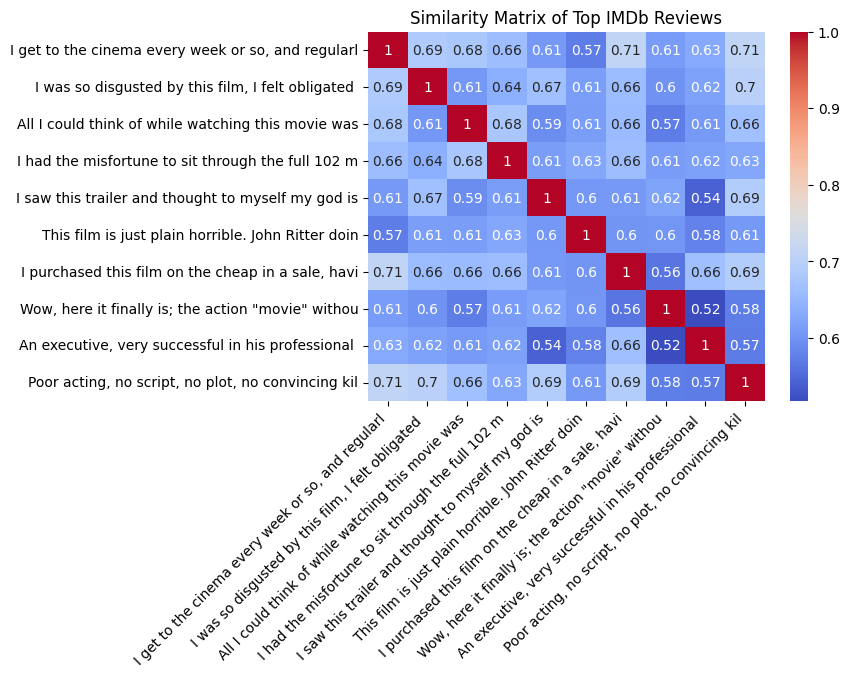

In [ ]:
from scipy.spatial.distance import cosine

def plot_similarity_matrix(reviews, corpus_embeddings, top_k=10):
    """
    Plot the similarity matrix for the top-k IMDb reviews based on semantic similarity.

    Args:
        reviews: List of IMDb review texts.
        corpus_embeddings: Embeddings of the IMDb reviews.
        top_k: Number of top similar reviews to consider.
    """
    # Calculate pairwise similarities
    similarities = util.pytorch_cos_sim(corpus_embeddings, corpus_embeddings).cpu().numpy()

    # Select the top-k most similar reviews by average similarity
    avg_similarities = similarities.mean(axis=1)
    top_indices = np.argsort(avg_similarities)[-top_k:][::-1]

    # Prepare similarity matrix for the top-k reviews
    matrix = np.zeros((top_k, top_k))
    for i, idx1 in enumerate(top_indices):
        for j, idx2 in enumerate(top_indices):
            # Calculate cosine similarity
            matrix[i, j] = 1 - cosine(corpus_embeddings[idx1], corpus_embeddings[idx2])

    # Plot heatmap
    titles = [reviews[i][:50] for i in top_indices]  # Truncate review texts for display
    sns.heatmap(matrix, xticklabels=titles, yticklabels=titles, cmap="coolwarm", annot=True)
    plt.xticks(rotation=45, ha="right")
    plt.title("Similarity Matrix of Top IMDb Reviews")
    plt.show()

# Example usage
plot_similarity_matrix(reviews, corpus_embeddings, top_k=10)


Here we have the similarity matrix of the top IMDb reviews in the dataset, showing how similar they are to each other. We observe that most of the reviews are moderately similar, which makes sense since they share overlapping themes, sentiments, or vocabulary, even if they differ in specific details.

If the reviews focused on very similar topics or sentiments (e.g., all positive or all negative), we would expect the similarity scores to be higher. The matrix provides insight into the clustering of reviews and their semantic relationships.